# Q1. Predicting housing prices

In this problem, you will generate models for predicting house prices from given house features. The file “house_prices.txt” contains the data.

There are four features used in this regression:

* one binary feature (whether or not the house has covered parking)
* one numerical feature (size, measure in thousands of square meters)
* two categorical features (architectural style and location)

Each of the categorial features is represented as a vector of size 3. This gives us feature vectors of size 8 in total for each house. 200 examples are given in the training set.

In [90]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [91]:
%%bash

gdown 1hLxbWVrnmSnZDGjvu8HeQex6ezbXeLB6

Downloading...
From: https://drive.google.com/uc?id=1hLxbWVrnmSnZDGjvu8HeQex6ezbXeLB6
To: /content/house_prices.txt
100%|██████████| 6.08k/6.08k [00:00<00:00, 26.3MB/s]


In [92]:
DATA_DIR = pathlib.Path("/content")

In [93]:
features = pd.read_csv(
    DATA_DIR / "house_prices.txt",
    delimiter = "\t",
    skiprows=[0, 1, 2, 3, 4],
    header=None,
    usecols=[0, 1, 2, 3, 4, 6, 7, 8],
    names=["parking", "sq_meters", "art_deco", "bungalow", "colonial", "west", "east", "north"],
    dtype=np.float32
)

target = pd.read_csv(
    DATA_DIR / "house_prices.txt",
    delimiter = "\t",
    skiprows=[0, 1, 2, 3, 4],
    header=None,
    usecols=[5],
    names=["price"],
    dtype=np.float32
)


In [94]:
features.head()

,parking,sq_meters,art_deco,bungalow,colonial,west,east,north
0,-1.0,0.1275,0.0,1.0,0.0,0.0,0.0,1.0
1,1.0,0.1100,1.0,0.0,0.0,1.0,0.0,0.0
2,-1.0,0.1375,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.1975,0.0,1.0,0.0,0.0,0.0,1.0
4,-1.0,0.1200,0.0,0.0,1.0,1.0,0.0,0.0


In [95]:
target

,price
0,0.300
1,0.335
2,0.286
3,0.512
4,0.295
...,...
195,0.727
196,0.407
197,0.523
198,0.313


## a) Split the dataset into training and testing sets

Split the dataset into training and testing sets. Keep 80% of the data for training and 20% of the data for testing.

In [96]:
df = features.head()

In [97]:
a = np.array([[2], [4], [-2], [5], [-1], [0.5], [0.6], [1]])
df.shape, a.shape

((5, 8), (8, 1))

In [98]:
df.to_numpy() @ a

array([[ 4.50999999],
       [ 0.94      ],
       [-1.84999999],
       [ 8.79000002],
       [-2.02000001]])



---



In [99]:
#Convert to ndarray for torch.from_numpy()
features = features.to_numpy()
target = target.to_numpy()

In [100]:
#Same as Homework1

ind = np.arange(200)
ind = np.random.permutation(ind)
x_train, x_test = features[ind[:160],:], features[ind[160:],:]
y_train, y_test = target[ind[:160],:], target[ind[160:],:]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(160, 8) (40, 8)
(160, 1) (40, 1)


## b) Build a neural network to predict house prices

Use the provided dataloaders, define a neural network with two hidden layers of 10 units each both with ReLU activation. The output unit should have no activation function.

In [101]:
import torch
from torch import nn, optim, utils

In [102]:
train_features_tensor = torch.from_numpy(x_train)
train_target_tensor = torch.from_numpy(y_train)

#define dataset
train_dataset = utils.data.TensorDataset(
    train_features_tensor,
    train_target_tensor
)

test_features_tensor = torch.from_numpy(x_test)
test_target_tensor = torch.from_numpy(y_test)

test_dataset = utils.data.TensorDataset(
    test_features_tensor,
    test_target_tensor
)

#define dataloader
train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=40, #batches, 40-40-40 training
    shuffle=True
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=40,
    shuffle=False  #notice no need to shuffle it for test
)

Define a neural network with two hidden layers of 10 units each both with ReLU activation. The output unit should have no activation function.

In [127]:
#Network Architecture Design
ni = x_train.shape[1] #number of columns which is 8 features
nh = 10
no = 1

model = nn.Sequential( #the sequential container with modules
    nn.Linear(ni, nh), #input layer
    nn.ReLU(), #activation function for input layer

    nn.Linear(nh, nh), #1st hidden layer
    nn.ReLU(), #activation function for 1st layer

    nn.Linear(nh, nh), #2nd hidden layer
    nn.ReLU(), #activation function for 2nd layer

    nn.Linear(nh, no) #output
)

## c) Train your neural network using gradient descent

Using mean square loss, train the network with an appropriate optimizer for a few hundred epochs and plot the loss versus the number of training epochs.

In [128]:
#REf: pytorch documentations https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

# Parameters for training
n_epoch = 150
learning_rate = 0.1

mse = nn.MSELoss() #torch.nn.MSELoss(size_average=None, reduce=None, reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.1) #Implements stochastic gradient descent

#Save loss & epoches for plotting
ls = []
epochs = []

for epoch in range(n_epoch):
   # Set the model to training mode - important for batch normalization and dropout layers
    model.train()

    for batch, (X, y) in enumerate(train_dataloader):
        y = y.float() #since X,y are tensors but need a float output for y

        # Forward pass
        pred = model(X)
        loss = mse(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 40 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{len(train_dataset):>5d}]")

    #Save loss & epoches for plotting
    ls.append(loss.item()) #averaging loss, current = loss.item(), (batch + 1) * len(X)
    epochs.append(epoch)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([40])) that is different to the input size (torch.Size([40, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


loss: 0.857339  [   40/  240]
loss: 0.731602  [   40/  240]
loss: 0.651000  [   40/  240]
loss: 0.698054  [   40/  240]
loss: 0.569988  [   40/  240]
loss: 0.585607  [   40/  240]
loss: 0.736244  [   40/  240]
loss: 0.617175  [   40/  240]
loss: 0.705651  [   40/  240]
loss: 0.719707  [   40/  240]
loss: 0.619686  [   40/  240]
loss: 0.675000  [   40/  240]
loss: 0.774774  [   40/  240]
loss: 0.759825  [   40/  240]
loss: 0.783915  [   40/  240]
loss: 0.606015  [   40/  240]
loss: 0.702211  [   40/  240]
loss: 0.624533  [   40/  240]
loss: 0.692674  [   40/  240]
loss: 0.650276  [   40/  240]
loss: 0.708403  [   40/  240]
loss: 0.469280  [   40/  240]
loss: 0.572866  [   40/  240]
loss: 0.557533  [   40/  240]
loss: 0.774954  [   40/  240]
loss: 0.571690  [   40/  240]
loss: 0.655271  [   40/  240]
loss: 0.737159  [   40/  240]
loss: 0.653450  [   40/  240]
loss: 0.735058  [   40/  240]
loss: 0.524944  [   40/  240]
loss: 0.622680  [   40/  240]
loss: 0.681277  [   40/  240]
loss: 0.77

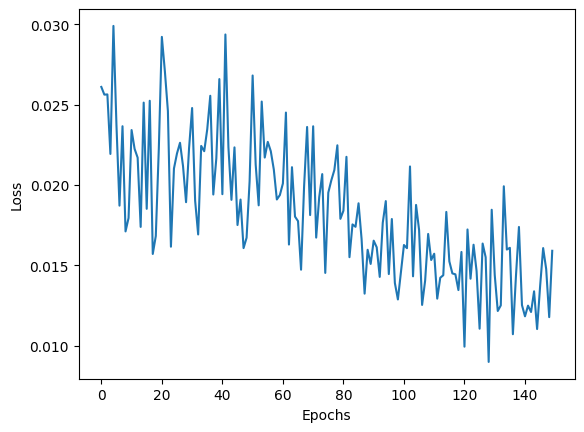

In [105]:
# Plot the loss versus the number of training epochs
plt.plot(epochs, ls)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

## d) Assess the performance of your neural network

Assess the performance of your neural network on the training data and the testing data. Comment on the results.

In [129]:
# For MSE Training data
# Set the model to evaluation mode - important for batch normalization and dropout layers
model.eval()
#torch.no_grad() ensures that no gradients are computed during test mode
with torch.no_grad():
    train_pred = model(train_features_tensor) #invoke the model's forward() method
    train_mse = mse(train_pred, train_target_tensor).item()

# For MSE testing data
model.eval()
with torch.no_grad():
    test_pred = model(test_features_tensor)
    test_mse = mse(test_pred, test_target_tensor).item()

# Print the MSE
print("MSE on Training Data: ", train_mse)
print("MSE on Testing Data (validation): ", test_mse)

#Good fit–validation error low, slightly higher than training error

MSE on Training Data:  0.6500571966171265
MSE on Testing Data (validation):  0.7348912358283997


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([240])) that is different to the input size (torch.Size([240, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([60])) that is different to the input size (torch.Size([60, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Q2. Classification

Consider the following simulated classification dataset with N = 300 samples labeled with one of three class labels.

In [107]:
%%bash

gdown 1_n5odu1KSpBAqO_Ddbqy2Ty0mG12Dr0A
gdown 1C7GK_uY0srlUdLfHfGa4IZcfthmmdROr

Downloading...
From: https://drive.google.com/uc?id=1_n5odu1KSpBAqO_Ddbqy2Ty0mG12Dr0A
To: /content/spiral_features.npy
100%|██████████| 4.93k/4.93k [00:00<00:00, 25.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1C7GK_uY0srlUdLfHfGa4IZcfthmmdROr
To: /content/spiral_target.npy
100%|██████████| 428/428 [00:00<00:00, 2.75MB/s]


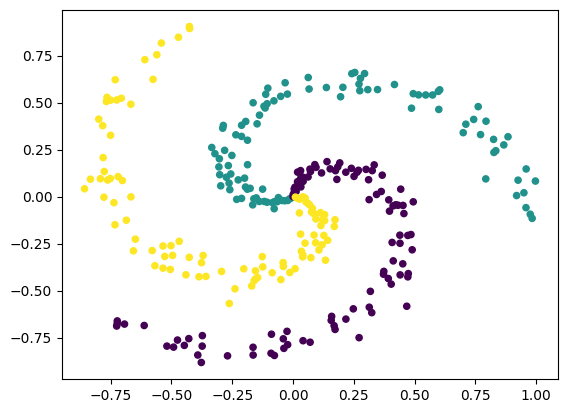

In [108]:
features = (np.load(DATA_DIR / "spiral_features.npy")
              .astype(np.float32))
target = np.load(DATA_DIR / "spiral_target.npy")

# visualize the data
plt.scatter(features[:, 0], features[:, 1], c=target, s=20)
plt.show()

## a) Split the dataset into training and testing sets

Split the dataset into training and testing sets. Keep 80% of the data for training and 20% of the data for testing.

In [109]:
#Same approach, features & target are already ndarray
ind = np.arange(300)
ind = np.random.permutation(ind)
x_train, x_test = features[ind[:240],:], features[ind[240:],:]
y_train, y_test = target[ind[:240]], target[ind[240:]]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(240, 2) (60, 2)
(240,) (60,)


## b) Train a logistic regression model

Using the provided datasets and dataloaders, build regression a 3-class logistic  classifier for this dataset using PyTorch and train it for 2000 epochs using gradient descent.

In [110]:
train_features_tensor = torch.from_numpy(x_train)
train_target_tensor = torch.from_numpy(y_train)

train_dataset = utils.data.TensorDataset(
    train_features_tensor,
    train_target_tensor
)

test_features_tensor = torch.from_numpy(x_test)
test_target_tensor = torch.from_numpy(y_test)

test_dataset = utils.data.TensorDataset(
    test_features_tensor,
    test_target_tensor
)

train_dataloader = utils.data.DataLoader(
    train_dataset,
    batch_size=40,
    shuffle=True
)

test_dataloader = utils.data.DataLoader(
    test_dataset,
    batch_size=40,
    shuffle=False
)

In [111]:
model = nn.Linear(2, 3)  # input size, number of classes using CPU

ce = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.05,momentum=0.1)

# For plotting
num_epochs = 2000
ls = []

# Train the model
for epoch in range(num_epochs):
    for X, y in train_dataloader:
        # Forward pass
        outputs = model(X)
        loss = ce(outputs, y)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    ls.append(loss.item())

## c) Assess the performance of your logistic regression model

Assess the performance of your model on the training data and the testing data in terms of both loss and accuracy. Comment on the results.

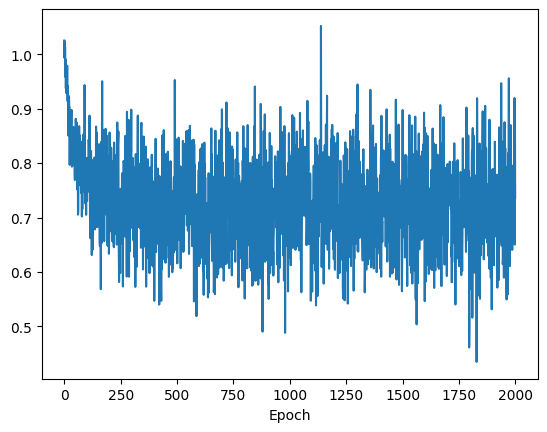

In [112]:
# Plot the loss
plt.plot(ls)
plt.xlabel('Epoch')
plt.show()

In [113]:
def plotClass(model, x, y):
    # Prediction
    model.eval()
    with torch.no_grad():
        z = model(torch.Tensor(x)) #probablity for each classes
        loss = ce(z, torch.Tensor(y).type(torch.LongTensor)) #cross-entropy
        _, yhat = torch.max(z.data, 1) #labeling it by choosing highest probablity
        accuracy = (yhat == torch.Tensor(y)).sum().item() / len(torch.Tensor(y)) #count the same label of yhat and actual data / all

    for i, color in enumerate(['red', 'green', 'blue']): #for three colors
        o = x[yhat == i] #plot one classes, then other
        plt.scatter(o[:, 0], o[:, 1], c=color, s=20)

    plt.show()

    print(f"Loss: {loss.item()}")
    print(f"Accuracy: {accuracy}")

Training Results


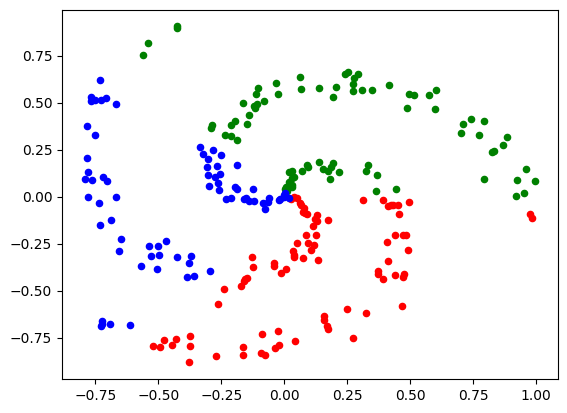

Loss: 0.7211281657218933
Accuracy: 0.5625


In [114]:
print("Training Results")
plotClass(model, x_train, y_train)

Testing Results


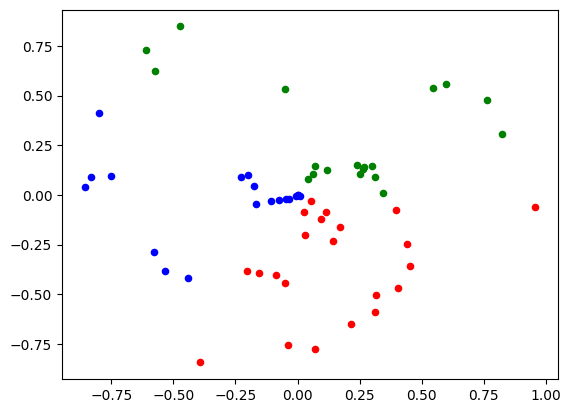

Loss: 0.8578851222991943
Accuracy: 0.4


In [115]:
print("Testing Results")
plotClass(model, x_test, y_test)

## d) Build a neural network classifier

Build a 3-class classifier using a neural network with one hidden layer of 100 units and a ReLU activation. Train the network with a gradient descent algorithm and for 2000 iterations.

In [116]:
# Set the hyperparameters
ni = x_train.shape[1]
nh = 100
no = 3
learning_rate = 0.1
n_epoch = 2000

# Create an instance of the model
model = nn.Sequential(
        nn.Linear(ni, nh),
        nn.ReLU(),
        nn.Linear(nh, nh), #one hidden layer
        nn.ReLU(),
        nn.Linear(nh, no)
)

In [117]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,momentum=0.1)

# Training loop
for epoch in range(n_epoch):
    # Forward pass and compute the loss
    outputs = model(train_features_tensor)
    loss = criterion(outputs, train_target_tensor)

    # Backward pass and optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## e) Assess the performance of your neural network

Assess the performance of your neural network on the training data and the testing data in terms of both loss and accuracy. Comment on the results.

Training Results


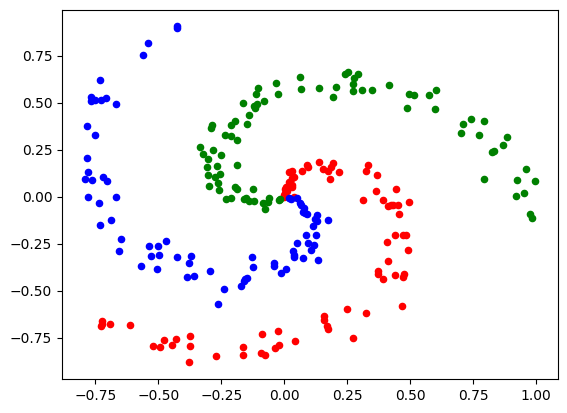

Loss: 0.03764643147587776
Accuracy: 0.9958333333333333


In [118]:
print("Training Results")
plotClass(model, x_train, y_train)

Testing Results


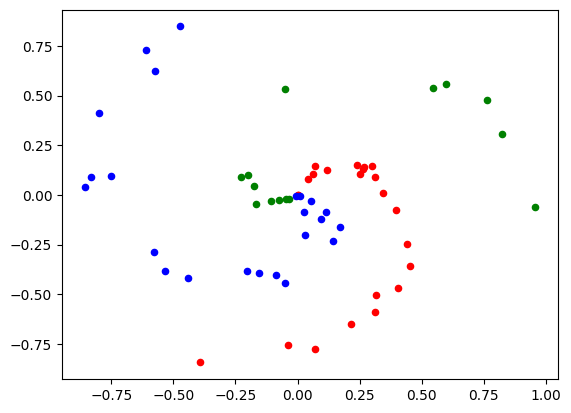

Loss: 0.0960298478603363
Accuracy: 0.95


In [119]:
print("Testing Results")
plotClass(model, x_test, y_test)

## e) Interpret the confusion matrix

Compute the confusion matrix for your classifier on both the training and testing data and interpret the results. You may either code your own confusion matrix or use the following function from Scikit-Learn.

In [120]:
from sklearn import metrics

In [121]:
from sklearn import metrics

# Evaluate model performance on training data
model.eval()
with torch.no_grad():
    train_outputs = model(train_features_tensor)
    _, train_predicted = torch.max(train_outputs.data, 1)
    train_confusion_matrix = metrics.confusion_matrix(train_target_tensor, train_predicted)

# Evaluate model performance on testing data
model.eval()
with torch.no_grad():
    test_outputs = model(test_features_tensor)
    _, test_predicted = torch.max(test_outputs.data, 1)
    test_confusion_matrix = metrics.confusion_matrix(test_target_tensor, test_predicted)

# Print the confusion matrices
print("Confusion Matrix - Training Data:")
print(train_confusion_matrix)
print("\nConfusion Matrix - Testing Data:")
print(test_confusion_matrix)

#Predicted  verse acual
#Testing data : Class 1 TP19 TN(22+19) FP0 FN0

Confusion Matrix - Training Data:
[[79  0  0]
 [ 0 84  0]
 [ 1  0 76]]

Confusion Matrix - Testing Data:
[[21  0  0]
 [ 1 14  1]
 [ 1  0 22]]


## f) Create your own deep neural network!

Create your own deep neural network and try to get as high an accuracy score on the test set as possible. Be creative: this is an opportunity for you to demonstrate what you can do!

I try

*   add 2 hidden layer
*   modify it to 200 neurons

Result
- test data : 1.0, 0.983, 1.0 for three trials


In [122]:
import torch.nn.functional as F

class myNet(nn.Module):
  def __init__(self,ni,nh,no):
    super().__init__()
    self.layerIn = nn.Linear(ni, nh)
    self.layer1 = nn.Linear(nh, nh) #1st hidden layer
    self.layer2 = nn.Linear(nh, nh) #2nd hidden layer
    self.layer3 = nn.Linear(nh, nh) #3rd hidden layer
    self.layerOut = nn.Linear(nh, no)

  def forward(self,x):
      x = F.relu(self.layerIn(x))
      x = F.relu(self.layer1(x))
      x = F.relu(self.layer2(x))
      x = F.relu(self.layer3(x))
      x = self.layerOut(x)
      return x

In [123]:
# Set the hyperparameters
ni = x_train.shape[1]
nh = 200
no = 3
learning_rate = 0.1
n_epoch = 2000

# Create an instance of the model
model = myNet(ni,nh,no)

In [124]:
ce = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.01)

# Training loop
for epoch in range(n_epoch):
    # Forward pass and compute the loss
    outputs = model(train_features_tensor)
    loss = ce(outputs, train_target_tensor)

    # Backward pass and optimize the model
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Training Results


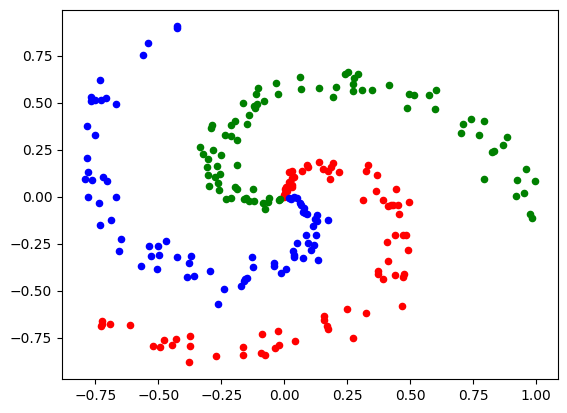

Loss: 0.005241223145276308
Accuracy: 1.0


In [125]:
print("Training Results")
plotClass(model, x_train, y_train)

Testing Results


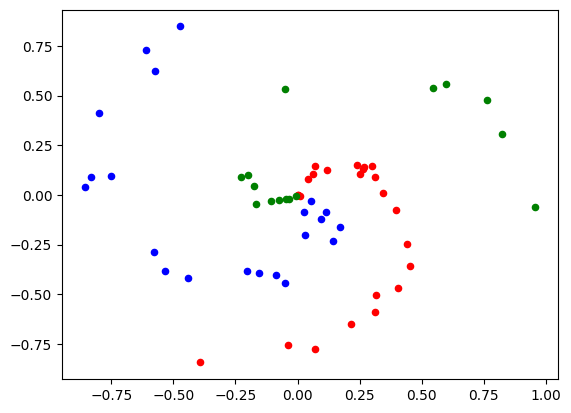

Loss: 0.09088240563869476
Accuracy: 0.95


In [126]:
print("Testing Results")
plotClass(model, x_test, y_test)